In [1]:
!pip install torch torchvision


In [40]:
!pip install kagglehub
!pip install pandas seaborn scikit-learn opencv-python-headless

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from PIL import Image
import cv2
import time
import pandas as pd
from glob import glob
import kagglehub

In [5]:
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset downloaded to: {dataset_path}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded to: /kaggle/input/chest-xray-pneumonia


In [6]:
# Define data directories based on the downloaded path
DATA_DIR = os.path.join(dataset_path, 'chest_xray')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [7]:
#Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 7
LEARNING_RATE = 0.001

In [8]:
#Preprocessing and Data Loading
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]# Use ImageNet stats for normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
}

In [9]:
# Load datasets using ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_transforms['val']),
    'test': datasets.ImageFolder(TEST_DIR, data_transforms['test'])
}

In [10]:
# Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False)
}

In [11]:
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
print(f"Training images: {len(image_datasets['train'])}")
print(f"Validation images: {len(image_datasets['val'])}")
print(f"Test images: {len(image_datasets['test'])}")

Classes: ['NORMAL', 'PNEUMONIA']
Training images: 5216
Validation images: 16
Test images: 624


In [14]:
# Calculate class weights for handling imbalance (used by all models for fair comparison)
print("Calculating Class Weights for Imbalance")
train_counts = {c: 0 for c in class_names}
for _, label in image_datasets['train']:
    train_counts[class_names[label]] += 1
print(f"Train counts: {train_counts}")
count_normal = train_counts['NORMAL']
count_pneumonia = train_counts['PNEUMONIA']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weight = torch.tensor([count_normal / count_pneumonia]).to(device)
print(f"Calculated pos_weight for loss: {pos_weight.item():.4f}")

Calculating Class Weights for Imbalance
Train counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Calculated pos_weight for loss: 0.3461


In [15]:
# Loss function: BCEWithLogitsLoss (combines Sigmoid + BCELoss)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [17]:
#print("Defining Baseline CNN Model")

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # Input: 3 x 224 x 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 112 x 112
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 56 x 56
            nn.BatchNorm2d(32)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 x 28 x 28
        )

        # Calculate flattened size
        # 64 * 28 * 28 = 50176
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1) # 1 output for binary classification
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [24]:
#Defining Transfer Learning Model Getters

def get_resnet_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    return model

def get_vgg_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 1)
    return model

def get_mobilenet_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 1)
    return model

In [19]:

#Defining Reusable Training/Evaluation Function

def train_and_evaluate(model, model_name, optimizer, criterion, dataloaders, num_epochs=EPOCHS):

    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    model = model.to(device)

    # To store metrics
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.float().view(-1, 1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        history['train_loss'].append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels_view = labels.float().view(-1, 1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_view)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5
                val_corrects += torch.sum(preds == labels.to(device).view_as(preds))

        val_loss = val_loss / len(dataloaders['val'].dataset)
        val_acc = val_corrects.double() / len(dataloaders['val'].dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    # Test Phase (on INTERNAL Kaggle test set)
    print(f"Evaluating {model_name} on Test Set")
    all_labels_internal = []
    all_preds_internal = []
    all_probs_internal = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_probs_internal.extend(probs.flatten())
            all_preds_internal.extend(preds.flatten())
            all_labels_internal.extend(labels.cpu().numpy())

    all_labels_internal = np.array(all_labels_internal)
    all_preds_internal = np.array(all_preds_internal)
    all_probs_internal = np.array(all_probs_internal)

    test_results = {
        'labels': all_labels_internal,
        'preds': all_preds_internal,
        'probs': all_probs_internal,
    }

    return model, history, test_results

In [20]:
#Starting Ablation Study (Training Models)

model_results = {}
trained_models = {}

#Train Baseline CNN
baseline_model = BaselineCNN()
# Note: We train ALL parameters for the baseline
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
baseline_model, baseline_history, baseline_results = train_and_evaluate(
    baseline_model, "Baseline CNN", optimizer_baseline, criterion, dataloaders, num_epochs=EPOCHS
)
model_results["Baseline CNN"] = baseline_results
trained_models["Baseline CNN"] = baseline_model


--- Training Baseline CNN ---
Epoch 1/7
Train Loss: 0.3604
Val Loss: 0.3031 Acc: 0.8125
Epoch 2/7
Train Loss: 0.0820
Val Loss: 0.2970 Acc: 0.8750
Epoch 3/7
Train Loss: 0.0781
Val Loss: 0.4722 Acc: 0.6875
Epoch 4/7
Train Loss: 0.0701
Val Loss: 0.3544 Acc: 0.8125
Epoch 5/7
Train Loss: 0.0698
Val Loss: 0.5139 Acc: 0.7500
Epoch 6/7
Train Loss: 0.0601
Val Loss: 0.3510 Acc: 0.8125
Epoch 7/7
Train Loss: 0.0602
Val Loss: 0.5688 Acc: 0.7500
Training complete in 10m 47s

--- Evaluating Baseline CNN on Test Set ---


In [21]:
#Train ResNet50
resnet_model = get_resnet_model()
# Note: We ONLY train the final `fc` layer for transfer learning
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=LEARNING_RATE)
resnet_model, resnet_history, resnet_results = train_and_evaluate(
    resnet_model, "ResNet50", optimizer_resnet, criterion, dataloaders, num_epochs=EPOCHS
)
model_results["ResNet50"] = resnet_results
trained_models["ResNet50"] = resnet_model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]



--- Training ResNet50 ---
Epoch 1/7
Train Loss: 0.1779
Val Loss: 0.1782 Acc: 0.9375
Epoch 2/7
Train Loss: 0.1103
Val Loss: 0.1493 Acc: 0.9375
Epoch 3/7
Train Loss: 0.1008
Val Loss: 0.1087 Acc: 0.9375
Epoch 4/7
Train Loss: 0.0884
Val Loss: 0.1628 Acc: 0.9375
Epoch 5/7
Train Loss: 0.0866
Val Loss: 0.1836 Acc: 0.9375
Epoch 6/7
Train Loss: 0.0835
Val Loss: 0.1365 Acc: 1.0000
Epoch 7/7
Train Loss: 0.0784
Val Loss: 0.0910 Acc: 0.9375
Training complete in 11m 38s

--- Evaluating ResNet50 on Test Set ---


In [22]:
print("Training VGG16")
vgg_model = get_vgg_model()
optimizer_vgg = optim.Adam(vgg_model.classifier[6].parameters(), lr=LEARNING_RATE)
vgg_model, vgg_history, vgg_results = train_and_evaluate(
    vgg_model, "VGG16", optimizer_vgg, criterion, dataloaders, num_epochs=EPOCHS
)
model_results["VGG16"] = vgg_results
trained_models["VGG16"] = vgg_model

Training VGG16
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 106MB/s]



--- Training VGG16 ---
Epoch 1/7
Train Loss: 0.1489
Val Loss: 0.2203 Acc: 0.6875
Epoch 2/7
Train Loss: 0.1094
Val Loss: 0.1732 Acc: 0.8125
Epoch 3/7
Train Loss: 0.1048
Val Loss: 0.1301 Acc: 0.8750
Epoch 4/7
Train Loss: 0.1040
Val Loss: 0.1225 Acc: 0.9375
Epoch 5/7
Train Loss: 0.1017
Val Loss: 0.1065 Acc: 0.9375
Epoch 6/7
Train Loss: 0.1010
Val Loss: 0.1596 Acc: 0.8125
Epoch 7/7
Train Loss: 0.1050
Val Loss: 0.1141 Acc: 0.9375
Training complete in 12m 42s

--- Evaluating VGG16 on Test Set ---


In [25]:
print("Training MobileNetV2")
mobilenet_model = get_mobilenet_model()
optimizer_mobilenet = optim.Adam(mobilenet_model.classifier[1].parameters(), lr=LEARNING_RATE)
mobilenet_model, mobilenet_history, mobilenet_results = train_and_evaluate(
    mobilenet_model, "MobileNetV2", optimizer_mobilenet, criterion, dataloaders, num_epochs=EPOCHS
)
model_results["MobileNetV2"] = mobilenet_results
trained_models["MobileNetV2"] = mobilenet_model


Training MobileNetV2
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 139MB/s]



--- Training MobileNetV2 ---
Epoch 1/7
Train Loss: 0.1717
Val Loss: 0.2727 Acc: 0.8125
Epoch 2/7
Train Loss: 0.1156
Val Loss: 0.1890 Acc: 0.8750
Epoch 3/7
Train Loss: 0.1001
Val Loss: 0.2686 Acc: 0.8125
Epoch 4/7
Train Loss: 0.0928
Val Loss: 0.2190 Acc: 0.8750
Epoch 5/7
Train Loss: 0.0916
Val Loss: 0.2924 Acc: 0.7500
Epoch 6/7
Train Loss: 0.0890
Val Loss: 0.3162 Acc: 0.8125
Epoch 7/7
Train Loss: 0.0903
Val Loss: 0.1706 Acc: 0.8750
Training complete in 10m 47s

--- Evaluating MobileNetV2 on Test Set ---


Text(0, 0.5, 'True Positive Rate')

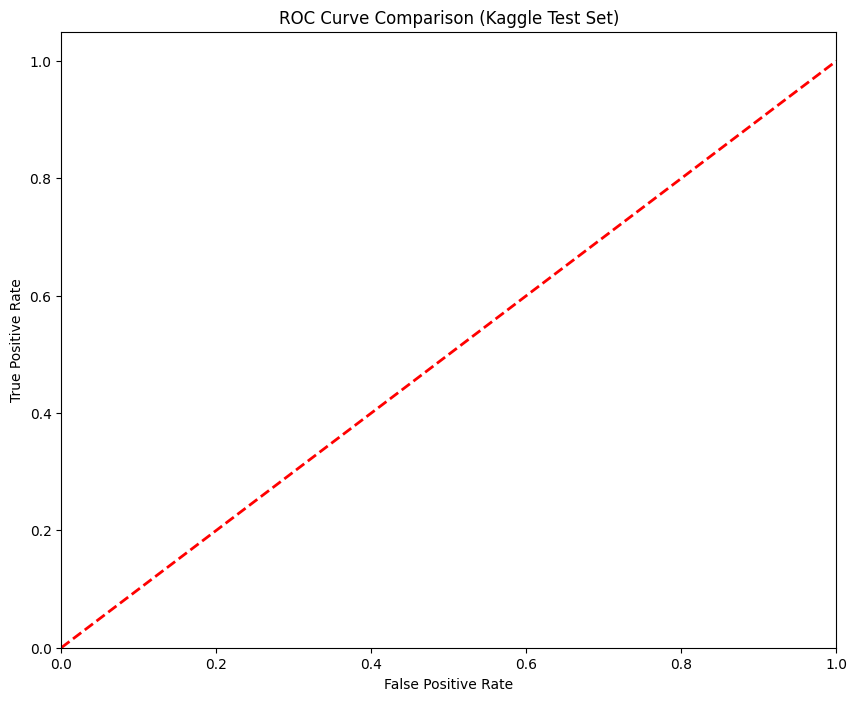

In [27]:
#Comparative Evaluation of All Models
#Plot 1:(Kaggle) Test Set ROC
plt.figure(figsize=(10, 8))
plt.title('ROC Curve Comparison (Kaggle Test Set)')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Results for Baseline CNN
Test Set 

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624

ROC-AUC Score: 0.9342


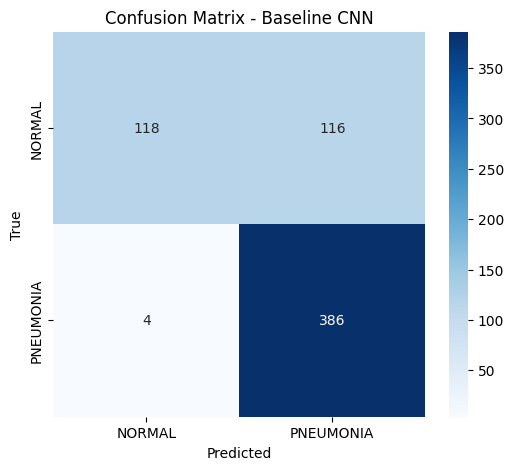

Results for ResNet50
Test Set 

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.81      0.86      0.83       234
   PNEUMONIA       0.91      0.88      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.86       624
weighted avg       0.87      0.87      0.87       624

ROC-AUC Score: 0.9405


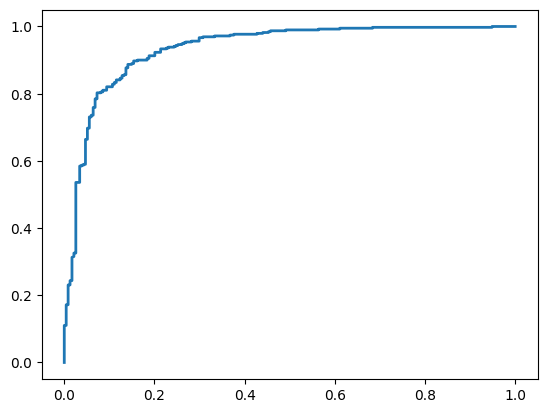

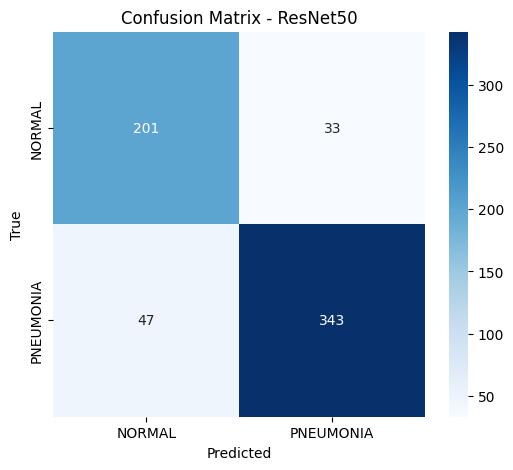

Results for VGG16
Test Set 

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.83      0.83       234
   PNEUMONIA       0.90      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624

ROC-AUC Score: 0.9336


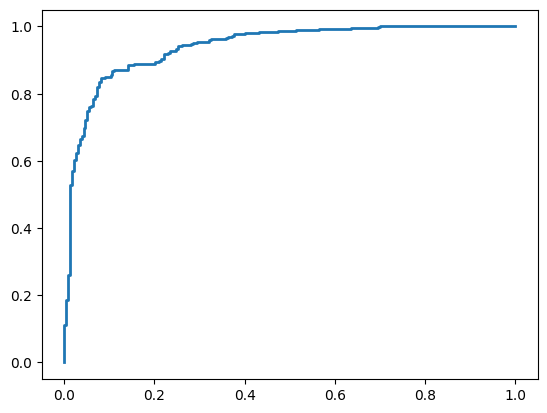

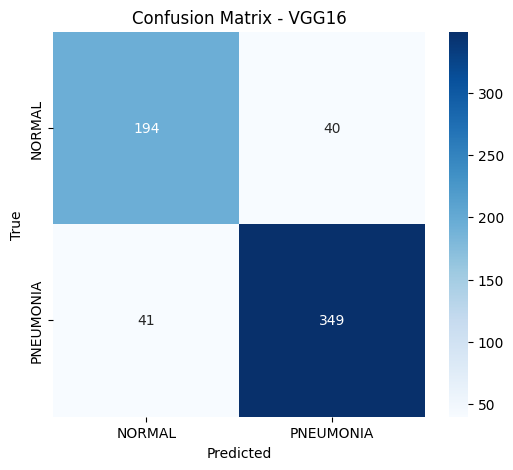

Results for MobileNetV2
Test Set 

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.82      0.85      0.84       234
   PNEUMONIA       0.91      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

ROC-AUC Score: 0.9365


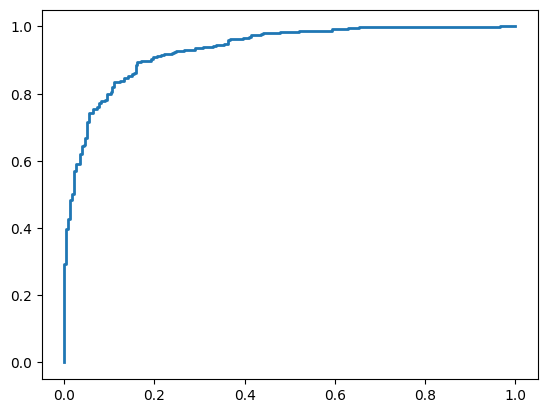

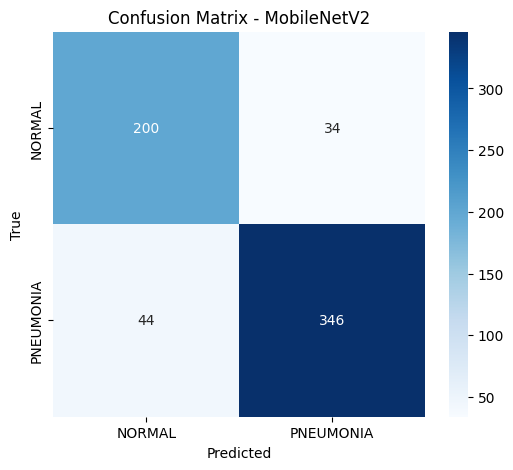

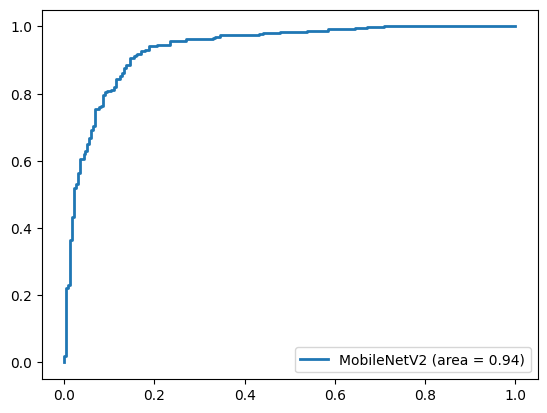

In [29]:
for model_name, results in model_results.items():
    print(f"Results for {model_name}")

    # Kaggle Results
    print("Test Set ")
    internal_labels = results['labels']
    internal_preds = results['preds']
    internal_probs = results['probs']

    # 1.Classification Report
    print("\nClassification Report:")
    print(classification_report(internal_labels, internal_preds, target_names=class_names))

    # 2.ROC-AUC Score
    auc = roc_auc_score(internal_labels, internal_probs)
    print(f"ROC-AUC Score: {auc:.4f}")

    # 3.Confusion Matrix
    cm = confusion_matrix(internal_labels, internal_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # 4.Add to comparative ROC Curve (Internal)
    fpr, tpr, _ = roc_curve(internal_labels, internal_probs)
    plt.figure(1) # Select the first ROC plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {auc:.2f})')


# Finalize the ROC plots
plt.figure(1)
plt.legend(loc="lower right")
plt.show()